# Introduction

This notebook shows how FairLearn can be used to detect issues with Fairness that are hard to detect with regular error metrics alone. We also export a dataframe so it can be used with Aequitas.

# Imports

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from fairlearn.widget import FairlearnDashboard

pd.options.display.float_format = "{:,.0f}".format

# Load Data

Here we load the heart disease dataset provided openly by 

* Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D., 
* University Hospital, Zurich, Switzerland: William Steinbrunn, M.D., 
* University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.,
* V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:Robert Detrano, M.D., Ph.D. 

on the UCI ML Repository: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [25]:
heart_disease_df = pd.read_csv(
    "heart_disease.csv", index_col=False, skipinitialspace=True
)

heart_disease_df["heart_disease"] = heart_disease_df["num"].apply(
    lambda x: 0 if x == 0 else 1
)

heart_disease_df = heart_disease_df.drop("num", axis=1)

In [26]:
heart_disease_df = heart_disease_df.replace("?", pd.NaT)
heart_disease_cleaned_df = heart_disease_df.dropna()
heart_disease_cleaned_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,63,1,1,145,233,1,2,150,0,2,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,2,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,3,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,4,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,241,0,0,123,1,0,2,0.0,7.0,1
298,45,1,1,110,264,0,0,132,0,1,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3,2,2.0,7.0,1
300,57,1,4,130,131,0,0,115,1,1,2,1.0,7.0,1


# EDA Plots

First we try to get a feeling of some of the features in the dataset and how they relate to our target: whether a person has a heart disease or not. We start by looking at age, then the maximum heart rate (thalach), followed by the influence of the sex of a person, and finally we look at the target itself.

## Age

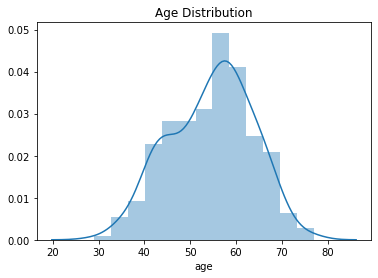

In [27]:
sns.distplot(heart_disease_cleaned_df["age"])
plt.title("Age Distribution")
plt.savefig("age.png", bbox_inches="tight", dpi=400)

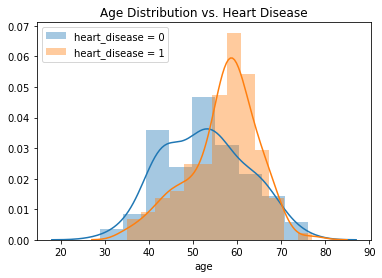

In [28]:
sns.distplot(
    heart_disease_cleaned_df[heart_disease_cleaned_df["heart_disease"] == 0]["age"],
    label="heart_disease = 0",
)
sns.distplot(
    heart_disease_cleaned_df[heart_disease_cleaned_df["heart_disease"] == 1]["age"],
    label="heart_disease = 1",
)
plt.legend()
plt.title("Age Distribution vs. Heart Disease")
plt.savefig("age_distplot.png", bbox_inches="tight", dpi=400)

## Maximum Heart Rate (Thalach)

In [10]:
sns.distplot(heart_disease_cleaned_df["thalach"])
plt.title("Distribution of Maximum Heart Rate")
plt.savefig("thalach_distplot.png", bbox_inches="tight", dpi=400)

In [11]:
sns.distplot(
    heart_disease_cleaned_df[heart_disease_cleaned_df["heart_disease"] == 0]["thalach"],
    label="heart_disease = 0",
)
sns.distplot(
    heart_disease_cleaned_df[heart_disease_cleaned_df["heart_disease"] == 1]["thalach"],
    label="heart_disease = 1",
)
plt.legend()
plt.title("Distribution of Maximum Heart Rate vs. Heart Disease")
plt.savefig("thalach_distplot_vs_heart_disease.png", bbox_inches="tight", dpi=400)

## Sex

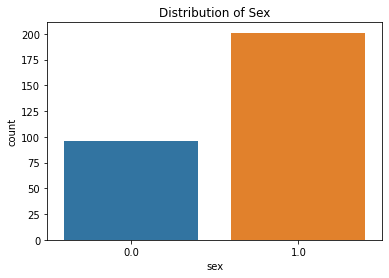

In [29]:
sns.countplot(data=heart_disease_cleaned_df, x="sex")
plt.title("Distribution of Sex")
plt.savefig("sex_amount.png", bbox_inches="tight", dpi=400)

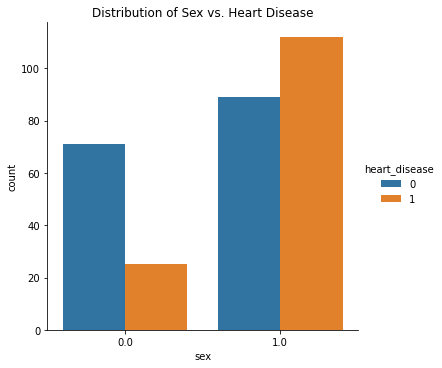

In [31]:
g = sns.catplot(
    x="sex", kind="count", hue="heart_disease", data=heart_disease_cleaned_df
)
plt.title("Distribution of Sex vs. Heart Disease")
plt.savefig("sex_vs_disease.png", bbox_inches="tight", dpi=400)

## Heart Disease (Target)

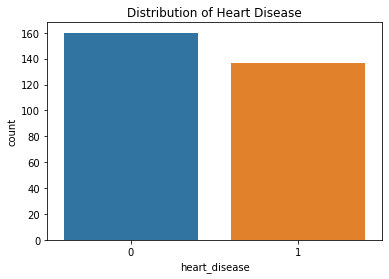

In [32]:
sns.countplot(data=heart_disease_cleaned_df, x="heart_disease")
plt.title("Distribution of Heart Disease")
plt.savefig("target.png", bbox_inches="tight", dpi=400)

# Model Training

To illustrate problems with Fairness, we will now train a simple decision tree which is able to achieve surprisingly good scores.

In [33]:
X = heart_disease_cleaned_df.iloc[:, :-1]
y = heart_disease_cleaned_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=43
)

In [34]:
clf = DecisionTreeClassifier(random_state=43, ccp_alpha=0.025, criterion="entropy")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [35]:
print(
    sklearn.metrics.classification_report(
        y_pred, y_test, target_names=["Heart Disease = 0", "Heart Disease = 1"]
    )
)

                   precision    recall  f1-score   support

Heart Disease = 0       0.88      0.84      0.86        50
Heart Disease = 1       0.81      0.85      0.83        40

         accuracy                           0.84        90
        macro avg       0.84      0.84      0.84        90
     weighted avg       0.85      0.84      0.84        90



In [36]:
with open("tree.dot", "w") as dotfile:
    dotfile.write(export_graphviz(clf, feature_names=X.columns, filled=True))

# FairLearn

Now we can use FairLearn to see how if our model was actually fair in the ways we deem important. If we look at the difference in recall between the two groups of sex, we will see a rather worrying issue, especially in the area of detecting heart disease...

In [38]:
FairlearnDashboard(
    sensitive_features=X_test[["sex"]],
    sensitive_feature_names=["sex"],
    y_true=y_test.tolist(),
    y_pred=[y_pred.tolist()],
)

FairlearnWidget(value={'true_y': [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1…

# Create output for Aequitas

Finally, we shape our results so they can be entered into the web interface of Aequitas for further analysis.

In [39]:
aequitas_df = heart_disease_df.loc[X_test.index, :]
aequitas_df["label_value"] = aequitas_df["heart_disease"]
aequitas_df = aequitas_df.drop("heart_disease", axis=1)
aequitas_df["score"] = y_pred
aequitas_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label_value,score
111,56,1,4,125,249,1,2,144,1,1,2,1.0,3.0,1,1
181,56,0,4,134,409,0,2,150,1,2,2,2.0,7.0,1,1
161,77,1,4,125,304,0,2,162,1,0,1,3.0,3.0,1,1
69,46,1,3,150,231,0,0,147,0,4,2,0.0,3.0,1,0
291,55,0,2,132,342,0,0,166,0,1,1,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,46,1,4,120,249,0,2,144,0,1,1,0.0,7.0,1,1
290,67,1,3,152,212,0,2,150,0,1,2,0.0,7.0,1,0
186,42,1,3,120,240,1,0,194,0,1,3,0.0,7.0,0,0
103,71,0,3,110,265,1,2,130,0,0,1,1.0,3.0,0,0


In [40]:
aequitas_df["sex"] = aequitas_df["sex"].apply(lambda x: "m" if x == 1.0 else "f")
aequitas_df.to_csv("aequitas_heart_disease.csv", index=False)